In [1]:
# Porting https://notebook.community/QuantScientist/Deep-Learning-Boot-Camp/day02-PyTORCH-and-PyCUDA/PyCUDA/05%20PyCUDA%20image%20processing
# to CUDA Python

In [2]:
import PIL
from PIL import Image as PILImage
import numpy as np

In [3]:
im = PILImage.open("PCSWV2ZZ.jpg")            

width, height = im.size
print("image size", width, height)

image size 1920 799


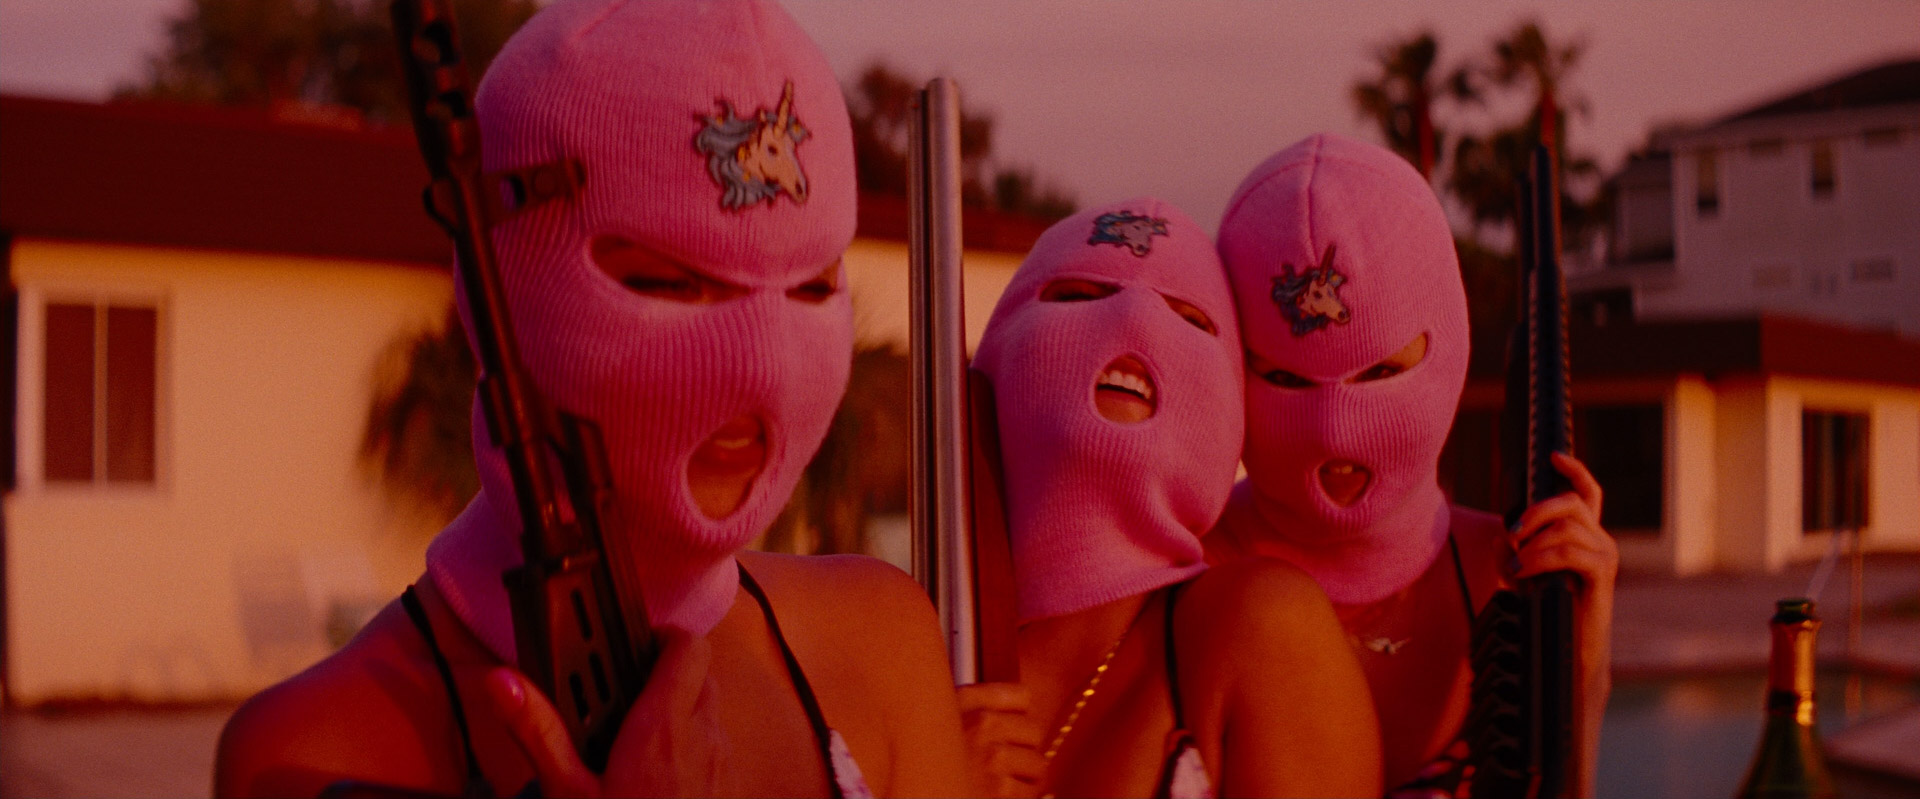

In [4]:
from IPython.display import Image 
display(im)


In [5]:
from cuda import cuda, nvrtc
import numpy as np

In [6]:
BLOCK_SIZE = 32



In [7]:
def ASSERT_DRV(err):
    if isinstance(err, cuda.CUresult):
        if err != cuda.CUresult.CUDA_SUCCESS:
            raise RuntimeError("Cuda Error: {}".format(err))
    elif isinstance(err, nvrtc.nvrtcResult):
        if err != nvrtc.nvrtcResult.NVRTC_SUCCESS:
            raise RuntimeError("Nvrtc Error: {}".format(err))
    else:
        raise RuntimeError("Unknown error type: {}".format(err))



In [8]:
grayscaleKernel = """
    extern "C" __global__
    void grayscale(float *r, float *g, float *b, float *gray, size_t height, size_t width)
    {
        int x = blockIdx.x * blockDim.x + threadIdx.x;
        int y = blockIdx.y * blockDim.y + threadIdx.y;
        if ((x < height) && (y < width)) 
        {
            int idx = x * width + y;
            float calc = (fmaxf(r[idx], fmaxf(g[idx], b[idx])) + fminf(r[idx], fminf(g[idx], b[idx]))) / 2.0;
            gray[idx] = calc;
           // gray[idx] = r[idx];
           //gray[idx] = 1.0;

        }
    }
    """

In [9]:
# Create program
err, grayscaleProg = nvrtc.nvrtcCreateProgram(str.encode(grayscaleKernel), b"grayscaleKernel.cu", 0, [], [])

# Compile program
opts = [b"--fmad=false", b"--gpu-architecture=compute_75"]
err, = nvrtc.nvrtcCompileProgram(grayscaleProg, 2, opts)

# Get PTX from compilation
err, ptxSize = nvrtc.nvrtcGetPTXSize(grayscaleProg)
ptx = b" " * ptxSize
err, = nvrtc.nvrtcGetPTX(grayscaleProg, ptx)

In [10]:
# Initialize CUDA Driver API
err, = cuda.cuInit(0)

# Retrieve handle for device 0
err, cuDevice = cuda.cuDeviceGet(0)

# Create context
err, context = cuda.cuCtxCreate(0, cuDevice)

In [11]:
# Load PTX as module data and retrieve function
ptx = np.char.array(ptx)
# Note: Incompatible --gpu-architecture would be detected here
err, module = cuda.cuModuleLoadData(ptx.ctypes.data)
ASSERT_DRV(err)
err, kernel = cuda.cuModuleGetFunction(module, b"grayscale")
ASSERT_DRV(err)

In [12]:
# calculate number of blocks in grid based on the image height and width
ix = int(round(height / BLOCK_SIZE))
iy = int(round(width / BLOCK_SIZE))


In [13]:
im = im.convert("RGB")
imn = np.asarray(im, dtype=np.float32) / 255.0 

r, g, b = imn[:, :, 0], imn[:, :, 1], imn[:, :, 2], 

# destination buffer
grayscale_result = np.zeros(shape=(height, width), dtype=np.float32)

print(r.shape, grayscale_result.shape)

# print(bufferSize, r.itemsize, width, height)

# allocate GPU memory
err, r_gpu = cuda.cuMemAlloc(r.nbytes)
err, g_gpu = cuda.cuMemAlloc(g.nbytes)
err, b_gpu = cuda.cuMemAlloc(b.nbytes)
err, gray_gpu = cuda.cuMemAlloc(grayscale_result.nbytes)

# stream existing rgb to GPU
err, stream = cuda.cuStreamCreate(0)

# host to device
err, = cuda.cuMemcpyHtoDAsync(r_gpu, np.ascontiguousarray(r).ctypes.data, r.nbytes, stream)
err, = cuda.cuMemcpyHtoDAsync(g_gpu, np.ascontiguousarray(g).ctypes.data, g.nbytes, stream)
err, = cuda.cuMemcpyHtoDAsync(b_gpu, np.ascontiguousarray(b).ctypes.data, b.nbytes, stream)

(799, 1920) (799, 1920)


In [14]:

# get addresses for our arguments
r_address = np.array([int(r_gpu)], dtype=np.uint64)
g_address = np.array([int(g_gpu)], dtype=np.uint64)
b_address = np.array([int(b_gpu)], dtype=np.uint64)
gray_address = np.array([int(gray_gpu)], dtype=np.uint64)

width_address = np.array(width, dtype=np.uint32)
height_address = np.array(height, dtype=np.uint32)

# run kernel w args
args = [r_address, g_address, b_address, gray_address, height_address, width_address]
print(args)

args = np.array([arg.ctypes.data for arg in args], dtype=np.uint64)

print(args)


err, = cuda.cuLaunchKernel(
   kernel,
   ix,  # grid x dim
   iy,  # grid y dim
   1,  # grid z dim
   BLOCK_SIZE,  # block x dim
   BLOCK_SIZE,  # block y dim
   1,  # block z dim
   0,  # dynamic shared memory
   stream,  # stream
   args.ctypes.data,  # kernel arguments
   0,  # extra (ignore)
)

# readback from device to host
err, = cuda.cuMemcpyDtoHAsync(grayscale_result.ctypes.data, gray_gpu, grayscale_result.nbytes, stream)


err, = cuda.cuStreamSynchronize(stream)

[array([139787396710400], dtype=uint64), array([139787403001856], dtype=uint64), array([139787409293312], dtype=uint64), array([139787415584768], dtype=uint64), array(799, dtype=uint32), array(1920, dtype=uint32)]
[93876643111104 93876641749536 93876643496512 93876643496480
 93876643498400 93876640598816]


In [15]:
grayscale_result.shape

(799, 1920)

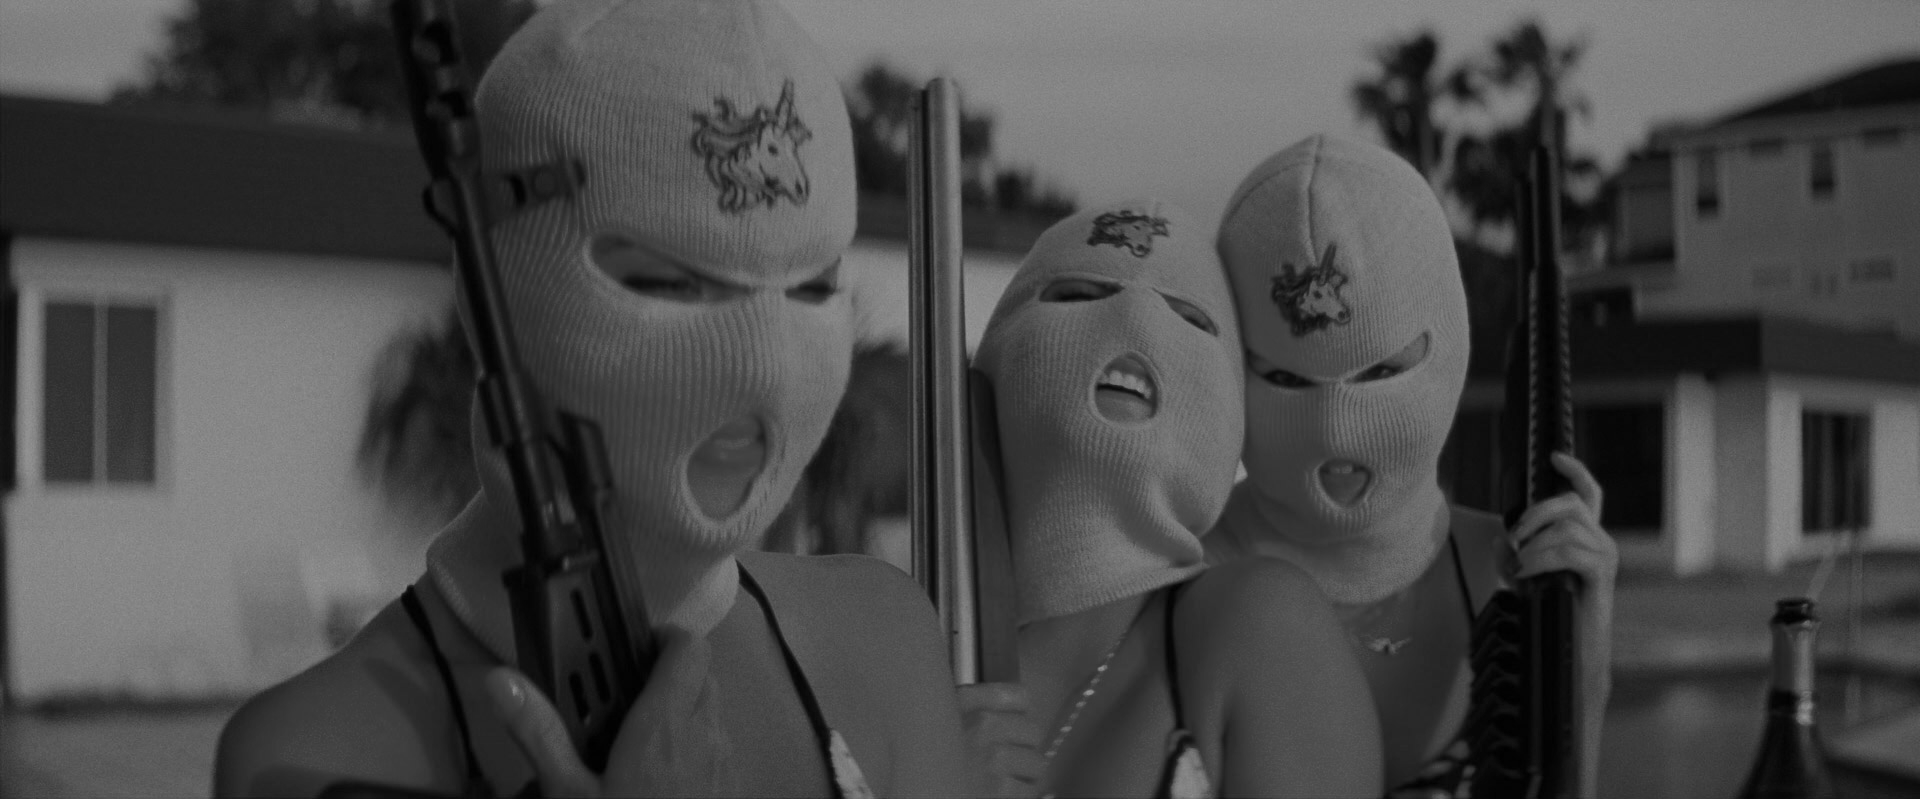

In [16]:
display( PILImage.fromarray( np.uint8(grayscale_result * 255) ))

In [17]:
err, = cuda.cuStreamDestroy(stream)
err, = cuda.cuMemFree(r_gpu)
err, = cuda.cuMemFree(g_gpu)
err, = cuda.cuMemFree(b_gpu)
err, = cuda.cuMemFree(gray_gpu)
err, = cuda.cuModuleUnload(module)
err, = cuda.cuCtxDestroy(context)

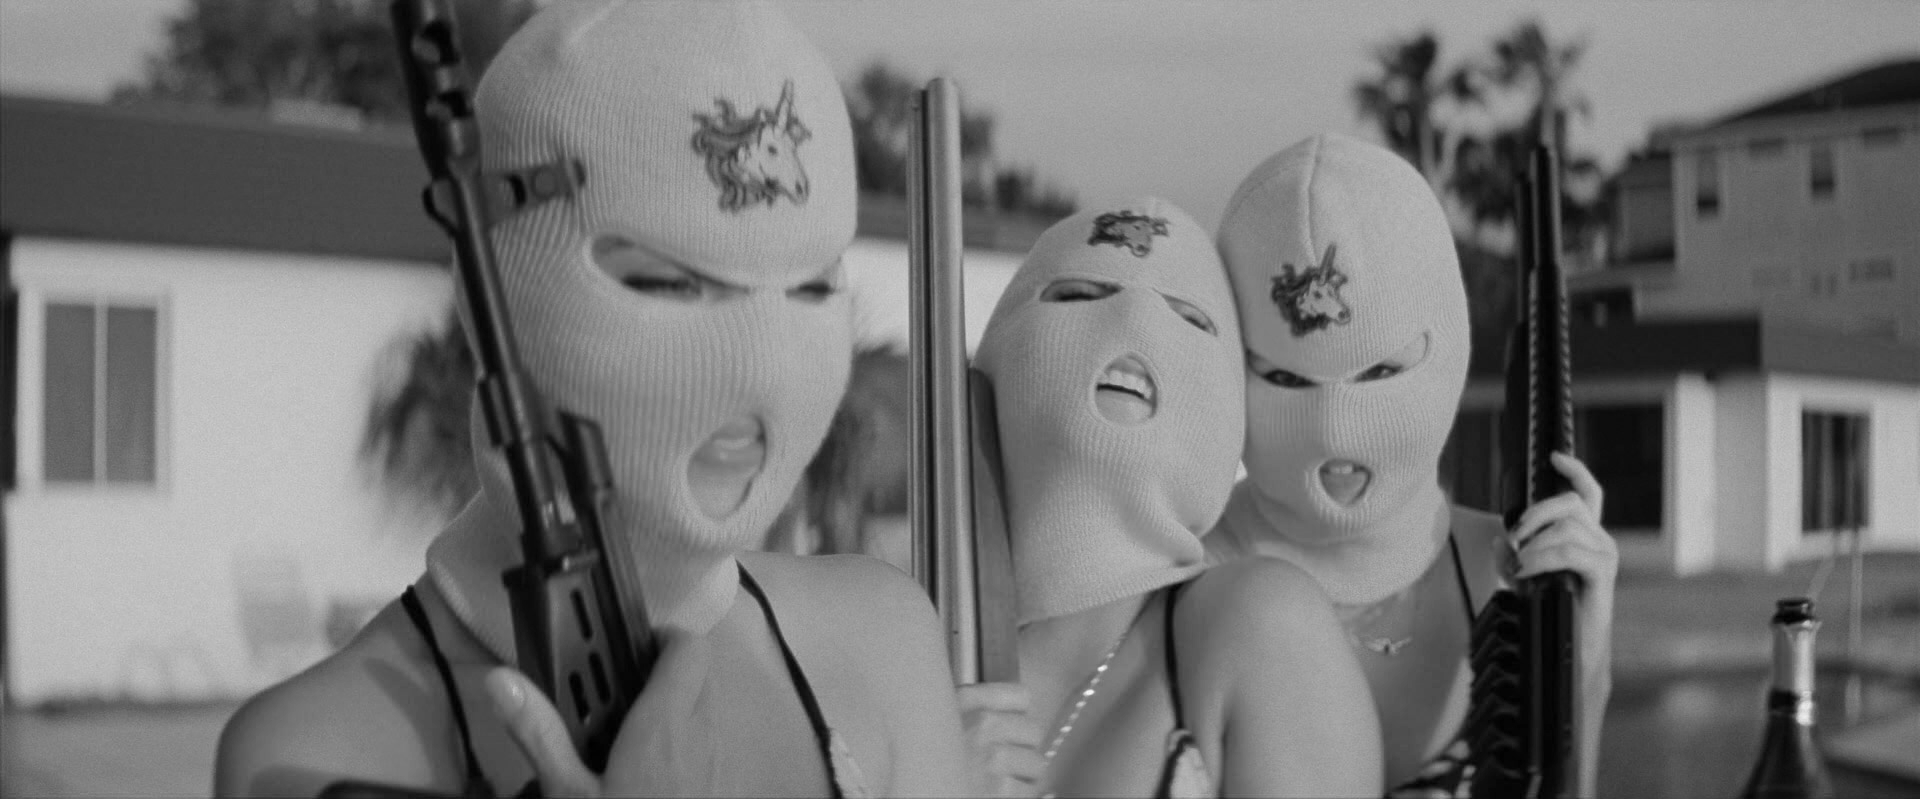

In [18]:
display( PILImage.fromarray( np.uint8(r * 255) ))